# Ames real estate data
We have some data named `data.csv` that contains property listings (property details + sale price). We will use this to try and demonstrate a really simple model that would help us determine if houses in "the wild" are interesting to us, given a budget of $200k.

We will mainly make use of the following libraries:

* `Pandas` for basic data transformations
* `Plotnine` for plotting
* `Sklearn` for some modelling

We will also make use of `numpy` some helper functions.

Note that the format of the notebook follows the generic helper questions set in the course.

In [245]:
import pandas as pd
import numpy as np
import plotnine as pn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, plot_roc_curve, precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

data_location = 'data.csv'

# Constants
BUDGET = 200000
TEST_PROP = 0.3

## Loading the data
Loading the data is straightforward to do with `Pandas`. Afterwards we always make a basic check of the data to ensure that everything looks to have loaded correctly.

Note that throughout it will be useful to have the data open in the Google sheet (refer to the `README`) - no one gets bonus points for making their life more difficult having to visualise everything in Pandas :D

In [3]:
property_data = pd.read_csv(data_location)

In [4]:
property_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [6]:
print(f'The data has {property_data.shape[0]} rows, {property_data.shape[1]} columns, and {property_data["Id"].nunique()} unique IDs.')

The data has 1460 rows, 81 columns, and 1460 unique IDs.


In [20]:
(property_data.isna().mean() * 100).sort_values(ascending=False).head(20)

PoolQC          99.520548
MiscFeature     96.301370
Alley           93.767123
Fence           80.753425
FireplaceQu     47.260274
LotFrontage     17.739726
GarageYrBlt      5.547945
GarageCond       5.547945
GarageType       5.547945
GarageFinish     5.547945
GarageQual       5.547945
BsmtFinType2     2.602740
BsmtExposure     2.602740
BsmtQual         2.534247
BsmtCond         2.534247
BsmtFinType1     2.534247
MasVnrArea       0.547945
MasVnrType       0.547945
Electrical       0.068493
Id               0.000000
dtype: float64

Everything seems to have loaded OK. The columns that have a few NULLs in them make sense since they refer to features a property might not have.

## Is the data useful?
To start with it seems like this data would be useful for our task. The `SalePrice` column seems to be what we want to look at. There is also month and year sold, `SaleType`, `SaleCondition`, and `MSZoning` columns that we should check out just in case we have data that isn't relevant to us.

The first things to do are to check the NULLs we have, as well as if the data behaves somewhat well for these columns, in addition to the type of data we have overall to make sure the data is valid for us.

In [85]:
def analyse_column(column, data):
    EXCEPTIONS = ['MoSold', 'YrSold', 'MSSubClass', 'YearBuilt', 'YearRemodAdd']
    print(f'The column {column} has {data[column].isna().sum()} nulls\n')
    
    print('The distribution looks like:')
    if (data[column].dtype == float or data[column].dtype == int) and column not in EXCEPTIONS:
        print(data[column].describe())
    else:
        print(f'The column has {(data[column] == "").sum()} empty cells')
        print((data[column].value_counts(normalize=True, dropna=False) * 100).astype(int).astype(str) + '%')
        
    print('\n\n')

In [86]:
columns = ['SalePrice', 'SaleType', 'SaleCondition', 'MSZoning', 'MoSold', 'YrSold']
for column in columns:
    analyse_column(column, property_data)

The column SalePrice has 0 nulls

The distribution looks like:
count      1323.000000
mean     184375.455782
std       78842.531657
min       39300.000000
25%      132500.000000
50%      167000.000000
75%      216668.500000
max      755000.000000
Name: SalePrice, dtype: float64



The column SaleType has 0 nulls

The distribution looks like:
The column has 0 empty cells
WD       87%
New       9%
COD       1%
ConLD     0%
ConLw     0%
ConLI     0%
Con       0%
CWD       0%
Name: SaleType, dtype: object



The column SaleCondition has 0 nulls

The distribution looks like:
The column has 0 empty cells
Normal     90%
Partial     9%
Name: SaleCondition, dtype: object



The column MSZoning has 0 nulls

The distribution looks like:
The column has 0 empty cells
RL         79%
RM         14%
FV          4%
RH          0%
C (all)     0%
Name: MSZoning, dtype: object



The column MoSold has 0 nulls

The distribution looks like:
The column has 0 empty cells
6     17%
7     16%
5     14%
4      9

So the target looks like it behaves well, which is good. The other columns are all informed, which is great too. We also note that the dates are OK for us - there is nothing very old here.

The only other comment I have is that we are only really interested in "normal" or "partial" sales. I'm not 100% sure what the others mean, but given the description of columns, they don't seem like the types of property we would be going for (we are not buying from a family member, for example).

### Building the target
Let's go ahead and remove the data not of interest and also mark the target. This doesn't impact our division of data into training and test, since in real life we won't be inputting properties that are of this type (it seems reasonable to assume that the adverts we see don't include adverts for family members, or foreclosures, for example...).

The target will simply be if the property is below our budget. We could do more here, like also set a lower limit, but we will look at this a bit later...

In [50]:
desired_sale_types = ['Normal', 'Partial']
property_data = property_data[property_data['SaleCondition'].isin(desired_sale_types)].reset_index(drop=True)

In [53]:
property_data['target'] = property_data['SalePrice'] <= BUDGET

## Splitting train and test
Let's quickly split up the train and test data. This is important to do early without too much previous work to make sure that the evaluation is fair. We will just take 30% of the data, randomly, as a quick approach.

Note that the default is to shuffle and not stratisfy.

In [137]:
train, test = train_test_split(property_data, test_size=TEST_PROP, random_state=0)
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

In [61]:
print(f'We have training data with {train.shape[0]} rows, and testing data with {test.shape[0]} rows')
print(f'The training data has {train.target.mean():.0%} positive examples')

We have training data with 926 rows, and testing data with 397 rows
The training data has 70% positive examples


We see that the majority of the data is within our budget.

## Deeper look into the information available
The next step is to really look into the data we have to potentially build our model. We are going to be a bit strict here and only take things that we could reasonably expect to have in real life and BEFORE we actually phone the seller. We assume that we have been by the house and have some of the details of the property. The options are:

* MSSubClass
* MSZoning
* LotArea
* LotFrontage
* Street
* Alley
* LotShape
* LandContour
* Utilities
* LotConfig
* LandSlope
* Neighborhood
* Condition1
* Condition2
* BldgType
* HouseStyle
* YearBuilt
* YearRemodAdd
* RoofStyle
* RoofMatl
* MasVnrType
* ExterQual
* ExterCond
* TotalBsmtSF
* 1stFlrSF
* 2ndFlrSF
* GrLivArea
* GarageType
* GarageCars
* GarageArea
* PavedDrive
* WoodDeckSF
* OpenPorchSF
* EnclosedPorch
* 3SsnPorch
* PoolArea
* Fence
* MiscFeature
* MoSold
* YrSold

We base the logic on what we might be able to tell from the exterior, and what information we should be able to find in the official registry. The basement area, for example, should be findable - but the quality would need an in person visit.

Now we need to get a feel for these to see what's useful. Things are NOT useful if they have limited information for us to use.

In [66]:
knowable_columns = [
    'MSSubClass', 'MSZoning', 'LotArea', 'LotFrontage', 'Street', 'Alley', 'LotShape', 
    'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 
    'Condition2', 'BldgType', 'HouseStyle', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 
    'RoofMatl', 'MasVnrType', 'ExterQual', 'ExterCond', 'TotalBsmtSF', '1stFlrSF', 
    '2ndFlrSF', 'GrLivArea', 'GarageType', 'GarageCars', 'GarageArea', 'PavedDrive', 
    'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'PoolArea', 'Fence', 
    'MiscFeature', 'MoSold', 'YrSold'
]

In [87]:
for column in knowable_columns:
    analyse_column(column, train)

The column MSSubClass has 0 nulls

The distribution looks like:
The column has 0 empty cells
20     36%
60     22%
50      9%
30      5%
120     5%
160     4%
80      4%
70      3%
90      2%
190     2%
45      1%
85      1%
75      0%
180     0%
40      0%
Name: MSSubClass, dtype: object



The column MSZoning has 0 nulls

The distribution looks like:
The column has 0 empty cells
RL         79%
RM         14%
FV          4%
RH          1%
C (all)     0%
Name: MSZoning, dtype: object



The column LotArea has 0 nulls

The distribution looks like:
count       926.000000
mean      10772.463283
std       11558.563244
min        1300.000000
25%        7740.500000
50%        9539.500000
75%       11425.750000
max      215245.000000
Name: LotArea, dtype: float64



The column LotFrontage has 170 nulls

The distribution looks like:
count    756.000000
mean      70.702381
std       23.177234
min       21.000000
25%       60.000000
50%       70.000000
75%       80.000000
max      313.000000
Nam

Misc comments:

* Some of the lot areas are really huge
* The street and alley data is very boring and not likely to be of much further use
* LotShape is probably fine to include as regular or irregular, but we wouldn't be able to tell the difference beyond that
* Utilities has nothing useful
* The LandSlope and LandContour can be combined to separate the data a bit more - but in reality it looks like only the LandContour is really all that useful
* Note that We should combine the condition1 and condition2 and also reduce the space a bit
* The year built and remodelled columns are quite diverse - weirdly there are a lot of 1950s for remoddeling
* The materials columns are quite basic and don't have too much to them
* When there is no second floor there is a 0

We don't want to spend a huge amount of time here, so we are going to pick out the pieces of information that seem most useful to us:

* Total and livable area
* Number of floors
* Neighbourhood
* Year built and refurbished
* Garage size
* Building type
* Lot shape and the "type" (i.e. config)
* Year sold

## Dividing train and validation
Again, let's divide train and validation, just before we run the different feature creations. We take 30% again.

In [74]:
interesting_columns = [
    'MSZoning', 'LotArea', 'LotShape', 'LandContour', 
    'LotConfig', 'Neighborhood', 'BldgType', 'HouseStyle', 
    'YearBuilt', 'YearRemodAdd', 'ExterCond', 'TotalBsmtSF', 
    '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'GarageCars', 'YrSold',
    'SalePrice', 'target'
]

In [75]:
train_train, train_val = train_test_split(train[interesting_columns], test_size=TEST_PROP, random_state=0)

In [76]:
train_train.head()

,MSZoning,LotArea,LotShape,LandContour,LotConfig,Neighborhood,BldgType,HouseStyle,YearBuilt,YearRemodAdd,ExterCond,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,GarageCars,YrSold,SalePrice,target
1115,RL,12393,IR2,Lvl,FR2,CollgCr,1Fam,2Story,2004,2005,TA,847,847,1101,1948,2,2006,195000,True
350,RL,5000,Reg,Lvl,Inside,SWISU,1Fam,1.5Fin,1924,1950,TA,1026,1026,665,1691,1,2010,127000,True
71,RM,10440,Reg,Lvl,Corner,OldTown,1Fam,2Story,1910,1981,TA,440,682,548,1230,2,2009,110000,True
67,RM,1596,Reg,Lvl,Inside,MeadowV,Twnhs,SLvl,1973,1973,TA,462,526,462,988,1,2009,91000,True
470,RL,10594,Reg,Lvl,Inside,Crawfor,1Fam,1.5Unf,1926,1950,TA,768,789,0,789,1,2007,96500,True


## Understanding year sold
The first thing I want to look at is if the year sold affects the price - it could be that prices took a huge hit at some point.

In [77]:
train_train.groupby('YrSold')['SalePrice'].median()

YrSold
2006    163000
2007    168500
2008    165250
2009    174750
2010    158000
Name: SalePrice, dtype: int64

So there is definitely a bit of a pattern here where the financial crash seems to have affected things. One approach to get rid of this effect would be to simply normalise the prices within the years - but we aren't going to go any further with this for now, just a good thing to point out.

## Building and fixing features
We are going to do a few things here to build features and fix them to get ready for some model. Note that for some of these we will go back and do it again on the full training data since there's no problem - but we will use the `train_train` to determine transformations without peaking (`random_state` ensures we keep consistency).

First we will do some things to even up the distributions of the variables and make sure we have good representation. Note that even 10% of the data is only around 100 points, so we should aim for at least that value.

In [83]:
def create_basic_features(input_col, comparison, new_name, valid_features):
    train[new_name] = train[input_col] == comparison
    valid_features.append(new_name)

In [138]:
valid_features = []

# Modify zoning to simply suggest low density
create_basic_features('MSZoning', 'RL', 'is_low_density', valid_features)

# If it is regular
create_basic_features('LotShape', 'Reg', 'is_regular_lot', valid_features)

# If level lot
create_basic_features('LandContour', 'Lvl', 'is_level_lot', valid_features)

# If a 1 family
create_basic_features('BldgType', '1Fam', 'is_1fam', valid_features)

# Reduce options for lot config
train.loc[~train['LotConfig'].isin(['Inside', 'Corner']), 'LotConfig'] = 'Other'
valid_features.append('LotConfig')

# Reduce neighbourhood
top_neighbourhoods = pd.DataFrame(train_train['Neighborhood'].value_counts(normalize=True)).query('Neighborhood > 0.05').index.tolist()
train.loc[~train['Neighborhood'].isin(top_neighbourhoods), 'Neighborhood'] = 'Other'
valid_features.append('Neighborhood')

# If has remodel - NOTE that chose to use the +2 because it seemed the most logical - remodelling the year after building is weird
train['has_remodel'] = train['YearRemodAdd'] > train['YearBuilt'] + 2
valid_features.append('has_remodel')

# Has no garage or a big garage
train['garage_type'] = np.where(train['GarageCars'] == 0, 'No garage', np.where(train['GarageCars'] == 1, 'Single car', 'Bigger'))
valid_features.append('has_remodel')

# No second floor
train['no_second_floor'] = train['2ndFlrSF'] == 0
valid_features.append('no_second_floor')

These are some basic features - now we have to make some slightly more complex ones. We want to look at the square footage and when it was built (to get an idea of age). Let's graph the variables.

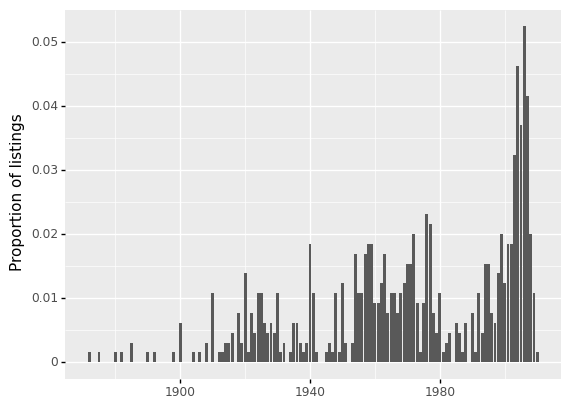

In [115]:
graph_data = train_train.YearBuilt.value_counts(normalize=True).reset_index()
graph = pn.ggplot(graph_data, pn.aes(x='index', y='YearBuilt')) + pn.geom_col() + pn.xlab('') + pn.ylab('Proportion of listings')
graph.draw();

There seem to be some big groups - post 1980, post 1940, and post 1900. Let's just make those groups without complicating ourselves too much.

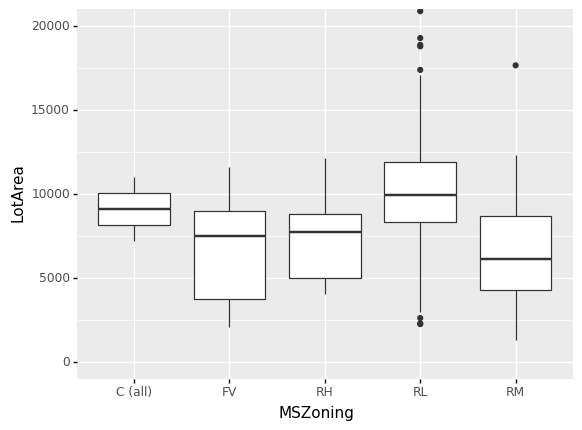

In [122]:
graph = pn.ggplot(train_train, pn.aes(x='MSZoning', y='LotArea')) + pn.geom_boxplot() + pn.coord_cartesian(ylim=(0, 20000))
graph.draw();

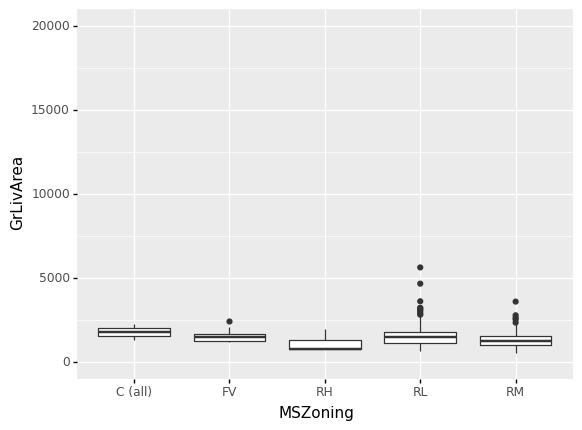

In [123]:
graph = pn.ggplot(train_train, pn.aes(x='MSZoning', y='GrLivArea')) + pn.geom_boxplot() + pn.coord_cartesian(ylim=(0, 20000))
graph.draw();

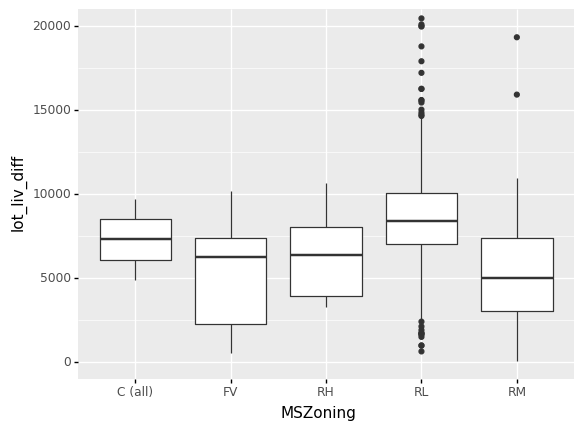

In [124]:
train_train['lot_liv_diff'] = train_train.LotArea - train_train.GrLivArea
graph = pn.ggplot(train_train, pn.aes(x='MSZoning', y='lot_liv_diff')) + pn.geom_boxplot() + pn.coord_cartesian(ylim=(0, 20000))
graph.draw();

We can see that the low density residential areas have most of our outliers, and otherwise we tend to be around 5k to 10k. We also see that the living area is quite a bit smaller but we still have some outliers. Let's also analyse this with respect to the target.

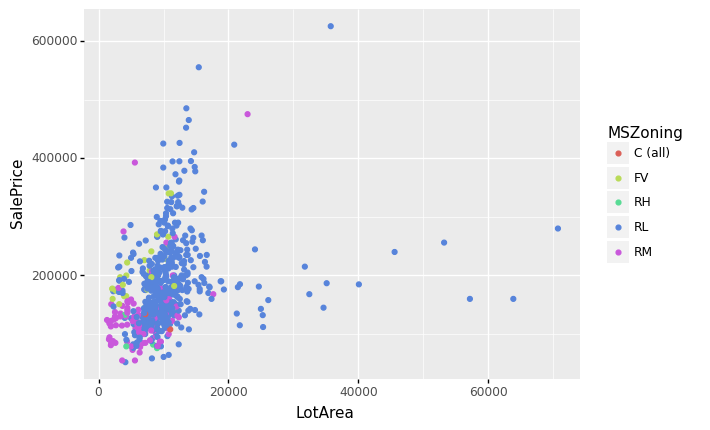

In [133]:
graph = pn.ggplot(train_train, pn.aes(x='LotArea', y='SalePrice', color='MSZoning')) + pn.geom_point()
graph.draw();

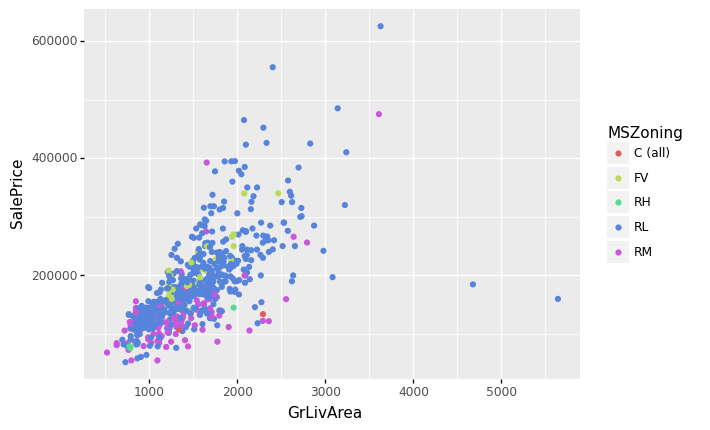

In [134]:
graph = pn.ggplot(train_train, pn.aes(x='GrLivArea', y='SalePrice', color='MSZoning')) + pn.geom_point()
graph.draw();

In [136]:
train_train[['LotArea', 'GrLivArea']].corr()

,LotArea,GrLivArea
LotArea,1.000000,0.403422
GrLivArea,0.403422,1.000000


We see something interesting here where the price of the lot changes with different rates depending on some third variable we have. This is probably related to more rural style homes. We do see, though, that above around 20k square feet, we don't actually have that many that were too expensive. The living area, overall, seems like a better variable to take into account, but there is probably some magic we could do here to take the area into account well too (e.g. we might find somewhere with a big garden but small living area).

In [139]:
# Classify year
cats = [0, 1900, 1940, 1980, 2020]
train['build_year_cats'] = pd.cut(train['YearBuilt'], cats, labels=['Pre-1900', 'Pre-War', 'Post-War', 'Modern'])
valid_features.append('build_year_cats')

# And just take the living area
valid_features.append('GrLivArea')

## Training a model
Now let's train a model using our features and the target. We will make this quite simple, trying a [logistic regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) and a [random forrest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html), just to highlight the difference.

Note that we will need to convert into dummy variables first. We shouldn't have any issues doing this with reproducibility later.

### Baseline
First let's get a baseline model. A nice example could be to do this with the neighborhoods and mark all the properties in neighborhoods with a certain proportion of expensive houses as not worth going.

In [148]:
train_train, train_val = train_test_split(train[['Neighborhood'] + ['target']], test_size=TEST_PROP, random_state=0)

In [161]:
thresholds = [0, 0.5, 0.6, 0.7, 0.8]
for threshold in thresholds:
    good_n = train_train.groupby('Neighborhood').target.mean().reset_index().query(f'target > {threshold}')['Neighborhood']
    train_val['prediction'] = np.where(train_val['Neighborhood'].isin(good_n), True, False)
    
    print(f'For a "decision threshold" of {threshold}, we get an accuracy of {accuracy_score(train_val.target, train_val.prediction):.0%}')

For a "decision threshold" of 0, we get an accuracy of 68%
For a "decision threshold" of 0.5, we get an accuracy of 74%
For a "decision threshold" of 0.6, we get an accuracy of 76%
For a "decision threshold" of 0.7, we get an accuracy of 76%
For a "decision threshold" of 0.8, we get an accuracy of 59%


Note that the threshold of 0 is just the baseline. We can see then that the accuracy is actually not that bad for some thresholds.

### Modelling
Now we transform the input and model!

In [145]:
# First check nulls!
train[valid_features].isna().sum()

is_low_density     0
is_regular_lot     0
is_level_lot       0
is_1fam            0
LotConfig          0
Neighborhood       0
has_remodel        0
has_remodel        0
no_second_floor    0
build_year_cats    0
GrLivArea          0
dtype: int64

In [164]:
train_train, train_val = train_test_split(
    pd.concat([pd.get_dummies(train[valid_features]), train['target']], axis=1), test_size=TEST_PROP, random_state=0
)

In [167]:
X_cols = [col for col in train_train if col != 'target']

#### Logistic regression

In [168]:
model = LogisticRegression(random_state=99).fit(train_train[X_cols], train_train['target'])

/Library/Python/3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [178]:
[(feat, coef) for feat, coef in zip(X_cols, model.coef_[0].tolist())]

[('is_low_density', -0.549517952610871),
 ('is_regular_lot', 0.11815810284597801),
 ('is_level_lot', 1.177096555828788),
 ('is_1fam', -0.6628846730582773),
 ('has_remodel', -0.07629248792413136),
 ('has_remodel', -0.07629248792413136),
 ('no_second_floor', -0.07629248792422481),
 ('GrLivArea', -0.07629248792422481),
 ('LotConfig_Corner', -1.1692595405387196),
 ('LotConfig_Inside', -0.0034605785283669606),
 ('LotConfig_Other', 1.285908690243562),
 ('Neighborhood_CollgCr', 1.2579108156383518),
 ('Neighborhood_Edwards', 1.2438981193973),
 ('Neighborhood_NAmes', 0.26390168549691245),
 ('Neighborhood_NridgHt', 1.6358563716519898),
 ('Neighborhood_OldTown', 1.0525156470444554),
 ('Neighborhood_Other', -1.1824079627823842),
 ('Neighborhood_Somerst', 2.0284632597043926),
 ('build_year_cats_Pre-1900', 0.7697350827419941),
 ('build_year_cats_Pre-War', -0.7803464585840396),
 ('build_year_cats_Post-War', 0.9727832060984344),
 ('build_year_cats_Modern', 1.1608344617387307)]

So the really strong features are things like it being modern and the difference neighborhoods. Note that when positive, it means that we predict a lower price. There are some weird things here like some more modern ones are cheaper - but it might be to do with the sizes. The neighborhoods hold a lot of the information overall.

Note that it would be good to see the statistical evaluation here by consulting statsmodels.

In [187]:
train_val['log_prediction_proba'] = model.predict_proba(train_val[X_cols])[:,1]

In [193]:
thresholds = [0, 0.5, 0.6, 0.7, 0.8]
for threshold in thresholds:
    train_val['log_prediction'] = train_val['log_prediction_proba'] > threshold
    
    print(f'For a "decision threshold" of {threshold}, we get an accuracy of {accuracy_score(train_val.target, train_val.log_prediction):.0%}')

For a "decision threshold" of 0, we get an accuracy of 68%
For a "decision threshold" of 0.5, we get an accuracy of 93%
For a "decision threshold" of 0.6, we get an accuracy of 91%
For a "decision threshold" of 0.7, we get an accuracy of 90%
For a "decision threshold" of 0.8, we get an accuracy of 84%


What if we reduced the variables even more?

In [225]:
reduced_valid_features = ['Neighborhood', 'GrLivArea', 'build_year_cats']
train_train, train_val = train_test_split(
    pd.concat([pd.get_dummies(train[reduced_valid_features]), train['target']], axis=1), test_size=TEST_PROP, random_state=0
)

In [226]:
X_cols = [col for col in train_train if col != 'target']

In [227]:
model = LogisticRegression(random_state=99).fit(train_train[X_cols], train_train['target'])

/Library/Python/3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [212]:
[(feat, coef) for feat, coef in zip(X_cols, model.coef_[0].tolist())]

[('GrLivArea', -0.0030626457163931476),
 ('Neighborhood_CollgCr', -0.1816574804853892),
 ('Neighborhood_Edwards', 1.6864791665173768),
 ('Neighborhood_NAmes', 0.5414107967396193),
 ('Neighborhood_NridgHt', -1.3788208930052488),
 ('Neighborhood_OldTown', 1.9421326166740098),
 ('Neighborhood_Other', 0.18758083386171437),
 ('Neighborhood_Somerst', -0.5965005926827024),
 ('build_year_cats_Pre-1900', 1.2595961313294515),
 ('build_year_cats_Pre-War', 0.5423380118396154),
 ('build_year_cats_Post-War', 1.0395053757810937),
 ('build_year_cats_Modern', -0.6408150709578395)]

Now the values make a bit more sense.

In [213]:
train_val['log_prediction_proba'] = model.predict_proba(train_val[X_cols])[:,1]

In [214]:
thresholds = [0, 0.5, 0.6, 0.7, 0.8]
for threshold in thresholds:
    train_val['log_prediction'] = train_val['log_prediction_proba'] > threshold
    
    print(f'For a "decision threshold" of {threshold}, we get an accuracy of {accuracy_score(train_val.target, train_val.log_prediction):.0%}')

For a "decision threshold" of 0, we get an accuracy of 68%
For a "decision threshold" of 0.5, we get an accuracy of 88%
For a "decision threshold" of 0.6, we get an accuracy of 89%
For a "decision threshold" of 0.7, we get an accuracy of 87%
For a "decision threshold" of 0.8, we get an accuracy of 83%


In [215]:
train_val.shape

(278, 15)

But we have lost some predictive power, it seems, although not much - as a drop in 1% only corresponds to around 2 or 3 examples.

#### RandomForrest

In [216]:
train_train, train_val = train_test_split(
    pd.concat([pd.get_dummies(train[valid_features]), train['target']], axis=1), test_size=TEST_PROP, random_state=0
)

In [217]:
X_cols = [col for col in train_train if col != 'target']

In [218]:
model = RandomForestClassifier(random_state=99).fit(train_train[X_cols], train_train['target'])

In [219]:
train_val['rf_prediction'] = model.predict(train_val[X_cols])

In [220]:
print(f'We get an accuracy of {accuracy_score(train_val.target, train_val.rf_prediction):.0%}')

We get an accuracy of 90%


In [221]:
model = RandomForestClassifier(random_state=99, min_samples_split=10).fit(train_train[X_cols], train_train['target'])

In [222]:
train_val['rf_prediction'] = model.predict(train_val[X_cols])

In [223]:
print(f'We get an accuracy of {accuracy_score(train_val.target, train_val.rf_prediction):.0%}')

We get an accuracy of 92%


So by modifying even just this single parameter, the performance increases, showing how we probably improved the generalisation accuracy.

## Predicting on test and getting the value
Let's just go ahead and predict on test now. We will use the reduced variables logistic regression because we used fewer variables without much lost, and this would also make a big difference to our manual search, since it would mean fewer data points to gather. We will take a threshold of 0.5.

Note that it is crucial that here we use the distribution of variables from train!

In [224]:
test.loc[~test['Neighborhood'].isin(top_neighbourhoods), 'Neighborhood'] = 'Other'

cats = [0, 1900, 1940, 1980, 2020]
test['build_year_cats'] = pd.cut(test['YearBuilt'], cats, labels=['Pre-1900', 'Pre-War', 'Post-War', 'Modern'])

In [229]:
reduced_valid_features = ['Neighborhood', 'GrLivArea', 'build_year_cats']
test_predict = pd.concat([pd.get_dummies(test[reduced_valid_features]), test['target']], axis=1)

In [230]:
X_cols = [col for col in test_predict if col != 'target']

In [231]:
test_predict['log_prediction_proba'] = model.predict_proba(test_predict[X_cols])[:,1]

In [232]:
test_predict['prediction'] = test_predict.log_prediction_proba > 0.5

In [233]:
print(f'We get an accuracy of {accuracy_score(test_predict.target, test_predict.prediction):.0%}')

We get an accuracy of 87%


Looks like things kept pretty stable - good news!

### What value do we get from this?
Let's see how many properties we would reduce the space by, and how we might use it.

NOTE that in reality we should do this on the validation set, but we are just trying to be quick.

In [235]:
print(f'We would only have to look at {test_predict.prediction.mean():.0%}')

We would only have to look at 71%


Ok so we did a bit better but it's still not that amazing. We could probably do a bit better by further filtering by some variable to give ourselves an order to look at the properties in:

In [239]:
test[test_predict.prediction].sort_values('GrLivArea', ascending=False).head(10)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,target,build_year_cats
204,584,75,RM,75.0,13500,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,0,7,2008,WD,Normal,325000,False,Pre-1900
298,489,190,RL,60.0,10800,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,0,5,2006,ConLD,Normal,160000,True,Pre-1900
35,1063,190,RM,85.0,13600,Pave,Grvl,Reg,Lvl,AllPub,...,NaN,NaN,0,9,2007,WD,Normal,90000,True,Pre-1900
130,67,20,RL,NaN,19900,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,0,7,2010,WD,Normal,180000,True,Post-War
240,1347,20,RL,NaN,20781,Pave,NaN,IR2,Lvl,AllPub,...,NaN,NaN,0,6,2006,WD,Normal,262500,False,Post-War
200,1224,20,RL,89.0,10680,Pave,NaN,Reg,Lvl,AllPub,...,MnPrv,NaN,0,10,2006,WD,Normal,137900,True,Post-War
224,1382,20,RL,NaN,12925,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,0,5,2008,WD,Normal,237500,False,Post-War
339,520,70,RL,53.0,10918,Pave,NaN,Reg,Lvl,AllPub,...,MnPrv,NaN,0,6,2009,WD,Normal,234000,False,Pre-War
95,935,20,RL,313.0,27650,Pave,NaN,IR2,HLS,AllPub,...,NaN,NaN,0,11,2008,WD,Normal,242000,False,Post-War
348,1249,75,RM,60.0,9600,Pave,Grvl,Reg,Lvl,AllPub,...,NaN,NaN,0,4,2008,WD,Normal,129500,True,Pre-War


In [251]:
test_predict.loc[test_predict.prediction, 'log_prediction_proba'].head(10)

2     0.914057
6     0.987534
11    0.947430
13    0.990928
15    0.949541
23    0.985589
29    0.931384
31    0.902643
36    0.985373
37    0.985092
Name: log_prediction_proba, dtype: float64

We can see that we are really confident on these - so actually they might be good candidates to look at, even if the sale price was a bit high originally.

Otherwise we might just get more strict on the probability. Let's plot the ROC curve.

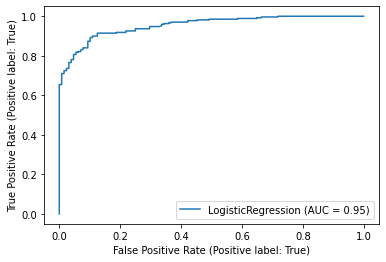

In [242]:
plot_roc_curve(model, test_predict[X_cols], test_predict.target)

We can see that we actually increase the false positive rate REALLY quickly, so we could be a lot stricter with the probability.

In [246]:
print(f'We get a precision of {precision_score(test_predict.target, test_predict.prediction):.0%}')

We get a precision of 89%


In [247]:
test_predict['prediction'] = test_predict.log_prediction_proba > 0.9

In [248]:
print(f'We get a precision of {precision_score(test_predict.target, test_predict.prediction):.0%}')

We get a precision of 100%


In [249]:
print(f'We would only have to look at {test_predict.prediction.mean():.0%}')

We would only have to look at 40%


So we get some idea of where we could take this - and we could also push the model to improve in this direction.